# Tau Data Analysis - UpROOT

In [1]:
import uproot as ur

import numpy as np
import awkward as ak
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import atlas_mpl_style as ampl
ampl.use_atlas_style()

In [3]:
analysis_base_21_2_201 = "21.2.201"
analysis_base_22_2_59 = "22.2.59"
analysis_base_22_2_60 = "22.2.60"
daod_MC16 = "MC16"
daod_MC20 = "MC20"

In [4]:
iters = ["e"]

In [5]:
bgks = ["data", "ttbar", "wtaunu", "wmunu", "wenu", "ztautau", "zmumu", "zee","znunu", "diboson"]
# bgks = ["diboson", "znunu", "zee", "zmumu", "ztautau", "wenu", "wmunu", "wtaunu","ttbar", "data"]
# bgks = ["data", "ttbar", 'wtaunu']

In [6]:
data_dictionary = {}
histograms_dictionary = {}

for i,background in enumerate(bgks):
    for j, iteration in enumerate(iters):
        path = f"/disk/atlas3/data_MC/{analysis_base_22_2_59}/PHYS/{daod_MC20}{iteration}/vector_XEplateau/{background}.root"
        tree = ur.open(path)['NOMINAL']

        ar = tree.arrays(library='ak')

        ar = ar[ar.eventClean != 0]
        ar = ar[ar.isBadTile == 0]
        ar = ar[ar.jet_n >= 3]
        ar = ar[ar.jet_pt[:, 0]/1000 >= 120]
        ar = ar[ar.jet_isBadTight[:, 0] != True]
        ar = ar[ar.jet_pt[:, 1]/1000 >= 25]
        ar = ar[ar.IsMETTrigPassed != 0]
        ar = ar[ar.met/1000 >= 180]
        ar = ar[ak.all(ar.mu_pt/1000 < 25, axis=1)]
        ar = ar[ar.tau_n == 1]
        ar = ar[ar.tau_JetRNNMedium[:, 0] != 0]
        ar = ar[ar.jet_delPhiMet[:, 0] >= 0.4]
        ar = ar[ar.jet_delPhiMet[:, 1] >= 0.4]
        ar = ar[ar.ht/1000 <= 800]
        ar = ar[ar.met/1000 <= 300]
        ar = ar[ar.tau_mtMet[:, 0]/1000 <= 80]

        ar['weight'] = ar.lumiweight*ar.mcEventWeight*ar.pileupweight*ar.beamSpotWeight*ar.jvt_weight*ar.bjet_weight*ar.tau_medium_weight*ar.ele_weight*ar.mu_weight

    if background == "data":
        data_dictionary[background] = ar
    else:
        histograms_dictionary[background] = ar

In [7]:
MC_full = ak.concatenate([histograms_dictionary[x] for x in histograms_dictionary], axis=0)

(0.0, 60000.0)

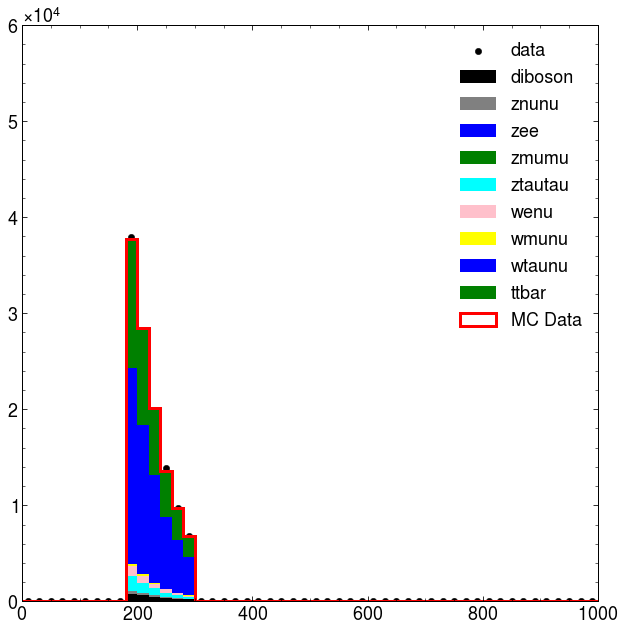

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# ax.set_xlabel("MET [GeV]")
# ax.set_ylabel("events/50 GeV")

n,bins,patches=plt.hist(
    data_dictionary['data'].met/1000,
    weights = data_dictionary['data'].weight,
    bins = np.linspace(0, 1000, 51),
    # histtype = 'bar',
    # stacked = False,
    # label = [label for label in met_dfs_dict],
    alpha=0,
    # label = "data"
    # color = "black"
)

plt.scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), n, marker='o', c='black', s=40, alpha=1, label="data")

ax.hist(
    [x for x in [histograms_dictionary[x].met/1000 for x in histograms_dictionary][::-1]],
    weights = [x for x in [histograms_dictionary[x].weight*0.92 for x in histograms_dictionary][::-1]],
    bins = np.linspace(0, 1000, 51),
    histtype = 'bar',
    stacked = True,
    # label = [x for x in histograms_dictionary.keys()],
    # label = labels,
    label = [y for y in [x for x in histograms_dictionary.keys()][::-1]],
    # color = ['green', 'blue', 'yellow', 'pink', 'cyan', 'green', 'blue', 'grey', 'black']
    color = ['black', 'grey', 'blue', 'green', 'cyan', 'pink', 'yellow', 'blue', 'green']
)

ax.hist(
    MC_full.met/1000,
    weights = MC_full.weight*0.92,
    bins = np.linspace(0, 1000, 51),
    histtype = 'step',
    stacked = True,
    label = ['MC Data'],
    # label = [r"$t \bar t$", r"$W \rightarrow \tau \nu$"]
    color = ['red'],
    linewidth = 3
)


# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles = handles[::-1], labels = labels)
plt.legend()

plt.xlim([0, 1000])


ymin, ymax = plt.ylim()
plt.ylim(ymin * 1.5, ymax * 1.5)